In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import getpass

user = getpass.getuser()

from itertools import product
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# reading the coeffs in ce and mc to obtain damage functions

ce_coeffs = pd.read_csv("/home/nsharma/repos/labor-code-release-2020/output/ce/ce_df_coeffs_SSP3.csv")
ce_coeffs = ce_coeffs[["year", "cons","beta1","beta2"]]

# change file location to 'no_cons_plots_scc/nocons_smooth_df_mean_output_SSP3.csv'
mc_sm_coeffs = pd.read_csv("/home/nsharma/repos/labor-code-release-2020/output/ce/damage_function_comparison/smooth_anomalies_df_mean_output_SSP3.csv") 
mc_sm_coeffs = mc_sm_coeffs[["year", "cons","beta1","beta2"]]

mc_nocons_coeffs = pd.read_csv("/home/nsharma/repos/labor-code-release-2020/output/ce/no_cons_plots_scc/nocons_smooth_df_mean_output_SSP3.csv") 
mc_nocons_coeffs = mc_nocons_coeffs[["year", "cons","beta1","beta2"]]

reg_values = pd.read_csv("/home/nsharma/repos/labor-code-release-2020/output/ce/reg_values.csv")
reg_values = reg_values.rename(columns={'temp': 'anomaly', 'value': 'damages_T'})

In [3]:
coeffs = pd.merge(mc_sm_coeffs, mc_nocons_coeffs, on= ['year'], how = 'inner') 
# coeffs = coeffs[coeffs['year'].isin(years_low)] # uncomment if comparison wanted only for years where ce damages < regular damages

fair = pd.read_csv("/home/nsharma/repos/labor-code-release-2020/output/ce/rcp85_anomalies.csv")

df = pd.merge(coeffs, fair, on= ['year'], how = 'inner')

# generate cons reg variables: damages due to pulse and level at rcp anomaly 
df['cons_df'] = (df.cons_x + df.fair_temperatures_anomaly_pulse * df.beta1_x + df.fair_temperatures_anomaly_pulse**2 * df.beta2_x)
df['level_cons'] = (df.cons_x + df.fair_temperatures_anomaly_rcp * df.beta1_x + df.fair_temperatures_anomaly_rcp**2 * df.beta2_x)
df['cons_damages'] = df.cons_df - df.level_cons

# generate non-cons reg variables: damages due to pulse and level at rcp anomaly 
df['no_cons_df'] = (df.cons_y + df.fair_temperatures_anomaly_pulse * df.beta1_y + df.fair_temperatures_anomaly_pulse**2 * df.beta2_y)
df['level_no_cons'] = (df.cons_y + df.fair_temperatures_anomaly_rcp * df.beta1_y + df.fair_temperatures_anomaly_rcp**2 * df.beta2_y)
df['no_cons_damages'] = df.no_cons_df - df.level_no_cons

# diff between cons and no-cons damages
df['diff'] = df.cons_damages - df.no_cons_damages

# slope = beta1 + 2*beta2*fair_anomaly for each case for rcp anomaly
df['slope_cons'] = (df.beta1_x + 2 * df.fair_temperatures_anomaly_rcp * df.beta2_x)
df['slope_no_cons'] = (df.beta1_y + 2 * df.fair_temperatures_anomaly_rcp * df.beta2_y)

# final df
df[['year', 'cons_damages', 'no_cons_damages', 'fair_temperatures_anomaly_rcp', 'diff', 'level_cons', 'level_no_cons', 'slope_cons', 'slope_no_cons']]#.to_csv('/home/nsharma/repos/labor-code-release-2020/output/ce/no_cons_plots_scc/rcp85_df.csv')

In [4]:
# generating df of anomalies between -5 to 20 in 1101 steps for each year between 2015 to 2100
temp_range = np.linspace(0, 10, 1101)
idx = product(range(2015,2100), temp_range) 
temps = np.stack([temp_range for _ in range(2015,2100)]).flatten() 
temps = pd.DataFrame(temps, index=[i for i,x in idx], columns=['temp'])
temps = temps.reset_index().rename(columns={"index":"year"})
# temps # checking things out

In [5]:
# certainty equivalence damage function
ce_df = pd.merge(ce_coeffs, temps, on= ['year'], how = 'inner') 
ce_df['ce_df_T'] = (ce_df.cons + ce_df.temp * ce_df.beta1 + ce_df.temp**2 * ce_df.beta2)
# ce_df # checking things out

# non-CE cloud labor mc damage function with smoothed anomnalies
mc_sm_df = pd.merge(mc_sm_coeffs, temps, on= ['year'], how = 'inner')
mc_sm_df['mc_sm_df_T'] = (mc_sm_df.cons + mc_sm_df.temp * mc_sm_df.beta1 + mc_sm_df.temp**2 * mc_sm_df.beta2)

mc_nocons_coeffs = pd.merge(mc_nocons_coeffs, temps, on= ['year'], how = 'inner')
mc_nocons_coeffs['mc_nocons_coeffs_T'] = (mc_nocons_coeffs.cons + mc_nocons_coeffs.temp * mc_nocons_coeffs.beta1 + mc_nocons_coeffs.temp**2 * mc_nocons_coeffs.beta2)

# mc_sm_df # checking things out

In [6]:
# overlaid plots with values used in regression i.e. year-2 to year+2
years = [2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 2097]
 
for y in years:
    print(y)
    year_range = range(y - 2, y + 3)
    print(year_range)
    reg_values.loc[reg_values.year.isin(year_range), 'year_assigned'] = y

# reg_values = reg_values[reg_values['year_assigned'].isin(years)]

2020
[2018, 2019, 2020, 2021, 2022]
2030
[2028, 2029, 2030, 2031, 2032]
2040
[2038, 2039, 2040, 2041, 2042]
2050
[2048, 2049, 2050, 2051, 2052]
2060
[2058, 2059, 2060, 2061, 2062]
2070
[2068, 2069, 2070, 2071, 2072]
2080
[2078, 2079, 2080, 2081, 2082]
2090
[2088, 2089, 2090, 2091, 2092]
2097
[2095, 2096, 2097, 2098, 2099]


In [7]:
mc_nocons_coeffs.year.unique()

array([2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025,
       2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036,
       2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047,
       2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057, 2058,
       2059, 2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068, 2069,
       2070, 2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079, 2080,
       2081, 2082, 2083, 2084, 2085, 2086, 2087, 2088, 2089, 2090, 2091,
       2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099])

In [8]:
reg_values.year_assigned.unique()

array([  nan, 2020., 2030., 2040., 2050., 2060., 2070., 2080., 2090.,
       2097.])

In [9]:
# df = pd.merge(mc_sm_df, reg_values, on = ['year_assigned'], how = 'inner')
# df

(0.13133849, 0.71939349)
(0.27373821, 1.2329999999999999)
(0.38432169, 1.983)
(0.50999999, 2.8629999)
(0.60000002, 3.9030001000000003)
(0.66000003, 5.2030001)
(0.68000001, 6.723)
(0.69, 8.1630001)
(0.69, 9.243)


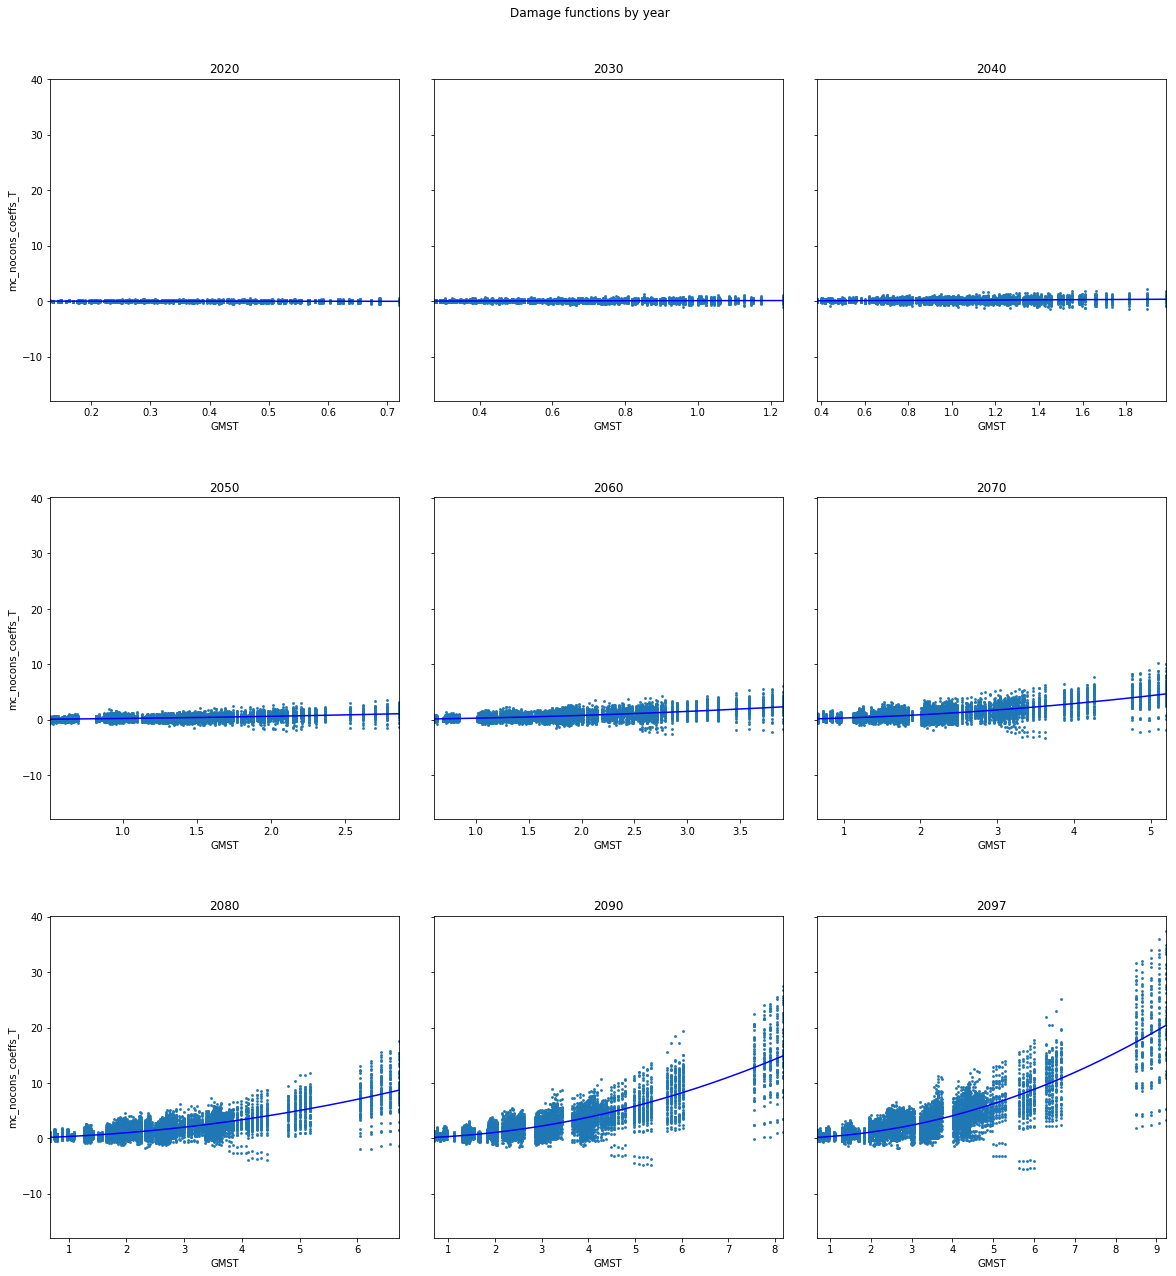

In [12]:

# g = sns.FacetGrid(df, col="year_assigned", col_wrap=4, sharey=True)
# g.map_dataframe(sns.lineplot, x='temp', y='ce_df_T', color = "blue", label="CE smooth anomalies").map_dataframe(sns.lineplot, x='temp', y='mc_df_T', color = "red", label="non-CE cloud non smooth anomalies")
# lgd = plt.legend(bbox_to_anchor=(-1,9.5), ncol=3)

fig, ax = plt.subplots(3,3,figsize=(20,20), sharex=False, sharey=True)

plt.subplots_adjust(wspace=0.1, hspace=0.3, top=0.93)

for i, year in enumerate(years):
    year_range = range(year - 2, year + 3)
    
    min_t= reg_values.loc[(reg_values['year_assigned']== year)].anomaly.min()
    max_t= reg_values.loc[(reg_values['year_assigned']== year)].anomaly.max()
    
    print(min_t, max_t)

    sns.scatterplot(data=reg_values.loc[reg_values.year_assigned.isin(year_range)],
               x='anomaly', y='damages_T', 
               s=4, ax=ax.flat[i], edgecolor='face')

    sns.lineplot(data=mc_nocons_coeffs.loc[mc_nocons_coeffs.year == year],
                 x='temp', y='mc_nocons_coeffs_T', color = "blue",
                 ax=ax.flat[i])

    ax.flat[i].set_xlim(min_t,max_t)
    ax.flat[i].set_xlabel('GMST')
    ax.flat[i].set_title(year)


fig.suptitle('Damage functions by year')

ax.flat[i].set_ylabel('Damages in trillions of 2019 USD')

plt.savefig("/home/nsharma/repos/labor-code-release-2020/output/ce/damage_function_comparison/years_df_with_point_nocons.pdf")


In [22]:
for i, year_assigned in enumerate(years):
    print(i)
    print(year_assigned)


0
2020
1
2030
2
2040
3
2050
4
2060
5
2070
6
2080
7
2090
8
2097
